- references
    - https://github.com/dave1010/tree-of-thought-prompting
    - https://github.com/holarissun/PanelGPT
    - https://www.promptingguide.ai/techniques/tot
    - https://github.com/kyegomez/tree-of-thoughts

In [3]:
from IPython.display import Image
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

## complex problem reasoning

```
Bob is in the living room.
He walks to the kitchen, carrying a cup.
He puts a ball in the cup and carries the cup to the bedroom.
He turns the cup upside down, then walks to the garden.
He puts the cup down in the garden, then walks to the garage.
Where is the ball?
```

- chatgpt 3.5
    - The ball is in the garden. When Bob puts the cup down in the garden, he also puts the ball, which was previously inside the cup, down in the garden.
- gpt 4
    - The ball is in the bedroom. When Bob turns the cup upside down in the bedroom, it implies that he empties the contents of the cup, which includes the ball, into the bedroom. Therefore, the ball remains there even as he moves to the garden and then to the garage.

## ToT

- highly structured prompt => 提升复杂问题的准确率；
    - chains(linear) => trees => graphs
    - Tree of Thoughts
        - https://arxiv.org/pdf/2305.10601.pdf
        - https://github.com/princeton-nlp/tree-of-thought-llm
    - 自回归（AR，AutoRegressive）模型天然的一种局限
        - linear reasoning，串行的，from left to right；
        - 走了一条错误的路径，天然地不支持回溯；
            - 4 5 6 10 => 24
            - (4+5) => left (9, 6, 10)
        - 幻觉导致出错；

- task specific, 受限于特定任务，manual design，没有那么 general
    - root node 就是初始的问题，每个节点都是一个thought（继承的CoT），一种思维；
    - proposals：对节点的展开（thought => subthoughts)，当前节点下最有可能的展开/推导；
        - gpt backend
    - evaluate：对节点的评估，保留 k 个，一种beam search width；
        - gpt backend
    - reduction, $f(n)\rightarrow f(n-1)$

In [18]:
Image(url='https://www.promptingguide.ai/_next/image?url=%2F_next%2Fstatic%2Fmedia%2FTOT.3b13bc5e.png&w=3840&q=75', 
      width=500)

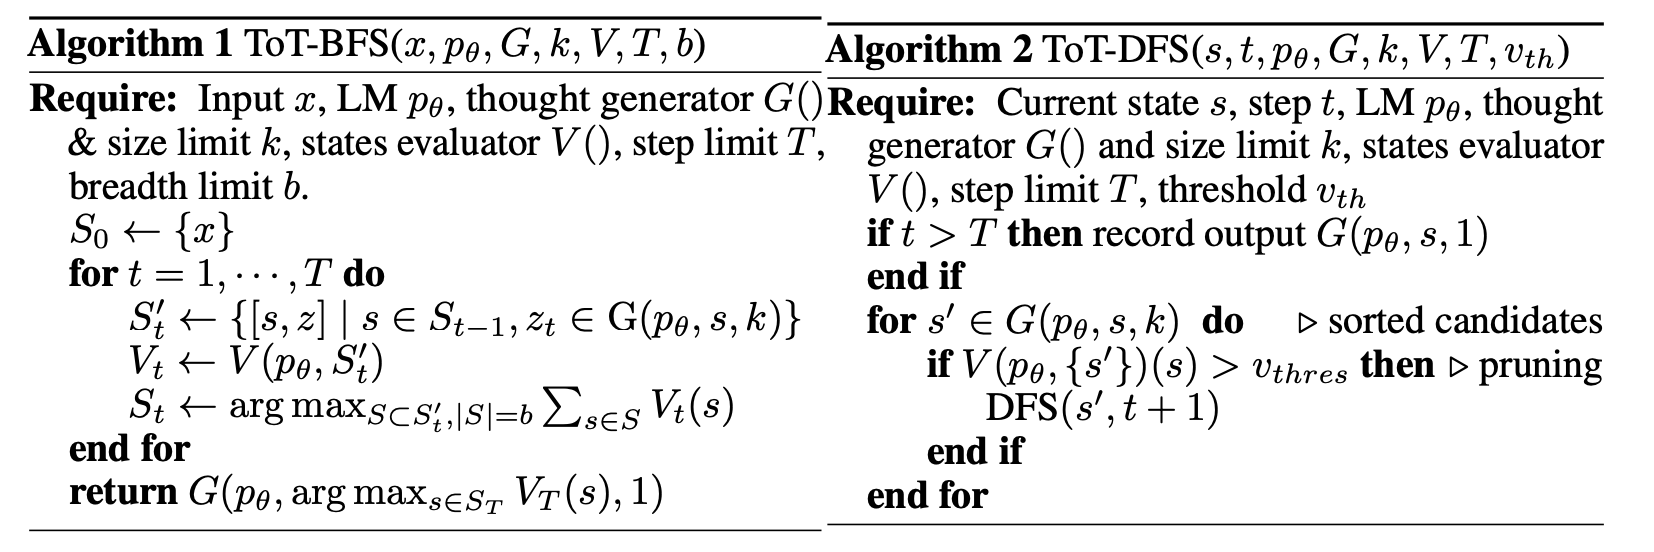

In [9]:
Image('../../imgs/tot_dfs_bfs.png', width=600)

### vanilla

```
Imagine three different experts are answering this question.
All experts will write down 1 step of their thinking,
then share it with the group.
Then all experts will go on to the next step, etc.
If any expert realises they're wrong at any point then they leave.
The question is...
```

### game 24

- game 24
    - 4 5 6 10

In [3]:
from itertools import permutations, product

# 定义一个求解函数，尝试通过加、减、乘、除运算得到结果24
def solve_for_24(numbers):
    # 定义所有可能的操作
    operations = [lambda a, b: a + b, lambda a, b: a - b, lambda a, b: a * b, lambda a, b: a / b]
    operation_symbols = ['+', '-', '*', '/']
    
    # 生成所有可能的数字排列组合以及所有可能的操作组合
    for nums in permutations(numbers):
        for ops in product(operations, repeat=3):
            # 尝试应用操作
            try:
                result = ops[0](nums[0], nums[1])
                result = ops[1](result, nums[2])
                result = ops[2](result, nums[3])
                
                # 如果结果为24（考虑浮点数的精度问题），返回这个组合
                if abs(result - 24) < 1e-6:
                    # 将操作符号与数字配对以便打印
                    op_symbols = [operation_symbols[operations.index(op)] for op in ops]
                    expression = f"(({nums[0]} {op_symbols[0]} {nums[1]}) {op_symbols[1]} {nums[2]}) {op_symbols[2]} {nums[3]}"
                    return expression
            except ZeroDivisionError:
                # 忽略除以零的错误
                continue
    # 如果没有找到解决方案，返回None
    return None


In [4]:
# 给定的数字
numbers = [4, 5, 6, 10]
solve_for_24(numbers)

'((4 * 5) - 6) + 10'

In [5]:
numbers = [2, 8, 8, 14]
solve_for_24(numbers)

'((14 - 8) / 2) * 8'

In [2]:
# first prompt with one shot
print('Input: 2 8 8 14\nPossible next steps:\n2 + 8 = 10 (left: 8 10 14)\n8 / 2 = 4 (left: 4 8 14)\n14 + 2 = 16 (left: 8 8 16)\n2 * 8 = 16 (left: 8 14 16)\n8 - 2 = 6 (left: 6 8 14)\n14 - 8 = 6 (left: 2 6 8)\n14 /  2 = 7 (left: 7 8 8)\n14 - 2 = 12 (left: 8 8 12)\nInput: 4 5 6 10\nPossible next steps:\n')

Input: 2 8 8 14
Possible next steps:
2 + 8 = 10 (left: 8 10 14)
8 / 2 = 4 (left: 4 8 14)
14 + 2 = 16 (left: 8 8 16)
2 * 8 = 16 (left: 8 14 16)
8 - 2 = 6 (left: 6 8 14)
14 - 8 = 6 (left: 2 6 8)
14 /  2 = 7 (left: 7 8 8)
14 - 2 = 12 (left: 8 8 12)
Input: 4 5 6 10
Possible next steps:



In [8]:
# first output
# 8 个候选
print('4 + 5 = 9 (left: 6 9 10)\n5 + 6 = 11 (left: 4 10 11)\n10 - 4 = 6 (left: 5 6 6)\n10 - 5 = 5 (left: 4 5 6)\n6 - 4 = 2 (left: 2 5 10)\n6 / 4 = 1.5 (left: 1.5 5 10)\n10 / 5 = 2 (left: 2 4 6)\n10 / 4 = 2.5 (left: 2.5 5 6)')

4 + 5 = 9 (left: 6 9 10)
5 + 6 = 11 (left: 4 10 11)
10 - 4 = 6 (left: 5 6 6)
10 - 5 = 5 (left: 4 5 6)
6 - 4 = 2 (left: 2 5 10)
6 / 4 = 1.5 (left: 1.5 5 10)
10 / 5 = 2 (left: 2 4 6)
10 / 4 = 2.5 (left: 2.5 5 6)


### evaluate 每个节点（proposal）

- vote
- value

#### vote

In [2]:
# A simple zero-shot vote prompt ("analyze chpoices below, 
# then conclude which is most promising for the instruction") is used to sample 5 votes at beoth steps

vote_prompt = '''Given an instruction and several choices, decide which choice is most promising. Analyze each choice in detail, then conclude in the last line "The best choice is {s}", where s the integer id of the choice.
'''
print(vote_prompt)

Given an instruction and several choices, decide which choice is most promising. Analyze each choice in detail, then conclude in the last line "The best choice is {s}", where s the integer id of the choice.



#### value

- `4 + 5 = 9 (left: 6 9 10)`：left 表示剩余，变成了什么

```
# prompt

Evaluate if given numbers can reach 24 (sure/likely/impossible)
10 14
10 + 14 = 24
sure
11 12
11 + 12 = 23
12 - 11 = 1
11 * 12 = 132
11 / 12 = 0.91
impossible
4 4 10
4 + 4 + 10 = 8 + 10 = 18
4 * 10 - 4 = 40 - 4 = 36
(10 - 4) * 4 = 6 * 4 = 24
sure
4 9 11
9 + 11 + 4 = 20 + 4 = 24
sure
5 7 8
5 + 7 + 8 = 12 + 8 = 20
(8 - 5) * 7 = 3 * 7 = 21
I cannot obtain 24 now, but numbers are within a reasonable range
likely
5 6 6
5 + 6 + 6 = 17
(6 - 5) * 6 = 1 * 6 = 6
I cannot obtain 24 now, but numbers are within a reasonable range
likely
10 10 11
10 + 10 + 11 = 31
(11 - 10) * 10 = 10
10 10 10 are all too big
impossible
1 3 3
1 * 3 * 3 = 9
(1 + 3) * 3 = 12
1 3 3 are all too small
impossible
6 9 10

# output
6 + 9 + 10 = 25
(10 - 6) * 9 = 4 * 9 = 36
(10 / 6) * 9 = 1.6 * 9 = 14.4
I cannot obtain 24 now, but numbers are within a reasonable range
likely
```

```
Input: 2 8 8 14
Possible next steps:
2 + 8 = 10 (left: 8 10 14)
8 / 2 = 4 (left: 4 8 14)
14 + 2 = 16 (left: 8 8 16)
2 * 8 = 16 (left: 8 14 16)
8 - 2 = 6 (left: 6 8 14)
14 - 8 = 6 (left: 2 6 8)
14 /  2 = 7 (left: 7 8 8)
14 - 2 = 12 (left: 8 8 12)
Input: 6 9 10
Possible next steps:
```